### Import Libraries and dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMClassifier

import random

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

/home/ali/miniconda3/envs/ali-gpu/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/ali/miniconda3/envs/ali-gpu/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/ali/miniconda3/envs/ali-gpu/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


The dataset I’m using here is a classification dataset where the task is about to classify a creature. There are 3 classes in the target function, ghouls, goblins and ghosts. We will try to predict the class of the creature based on independent characteristics.

Now before moving forward let’s have a quick look at the training set:

In [2]:
train_data.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


### Data Preparation

Let’s prepare the tarin_data for the LightGBM classifier. I will change the type of the categorical column from colour, and also change the target column, “type”, to full. The color column is nominal, so we’ll be using hot encoding, but in pandas, there is the “get_dummies” function which is very useful, easy to use, and does the same with hot encoding.

The Type column is also nominal, but being the target column we have to use Label Encoder. I will show you 2 approaches to converting categorical columns. One of them is LabelEncoder and the other is the map function. You can use whatever you want:

In [3]:
train_data = pd.get_dummies(train_data, columns=["color"], prefix=["color"])
map_type = {"Ghoul":1, "Goblin":2, "Ghost":0}   # change ghoul, goblin, ghost to 1, 2 and 0
train_data.loc[:, "type"] = train_data.type.map(map_type)

train_data = train_data.set_index("id")

/tmp/ipykernel_19412/1274733767.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_data.loc[:, "type"] = train_data.type.map(map_type)


The independent characteristics are designated by “X” and the dependent function is designated by “y”. 40% of train_data is allocated for the tests:

In [5]:
X = train_data.drop(["type"],axis=1)
y = train_data.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### LightGBM Classifier

First of all, we need to define the parameters and intervals. The parameters must be defined in a dictionary. The LightGBM classification model will try all the intervals we have set and try to find the optimal settings to get the best score. You can add more parameters if you want, but remember, more parameters mean more time:

In [7]:
param_grid = {
    'class_weight': [None, "balanced"],
    'boosting_type': ['gbdt','goss','dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': [0.01,0.1,0.5],
    'subsample_for_bin': [20000,50000,100000,120000,150000],
    'min_child_samples': [20,50,100,200,500],
    'colsample_bytree': [0.6,0.8,1],
    'max_depth': [5,10,50,100]
}

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)  # Train the lgbm on train sets

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 8
[LightGBM] [Info] Start training from score -1.168571
[LightGBM] [Info] Start training from score -1.045969
[LightGBM] [Info] Start training from score -1.085189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier()

A total of 3,240,000 adjustments were applied to the oar, the treatment lasted 8 hours 46 minutes. A very long time, and if you add more parameters the time will be longer:

In [11]:
lgbm_tuned = LGBMClassifier(boosting_type='gbdt',
                            class_weight = None,
                            min_child_samples = 20,
                            num_leaves = 30,
                            subsample_for_bin = 20000,
                            learning_rate=0.01,
                            max_depth=10,
                            n_estimators=40,
                            colsample_bytree=0.6) #LightGBM Classifier with optimum parameters
lgbm_tuned.fit(X_train, y_train)

y_test_pred = lgbm_tuned.predict(X_test)  #Predicting X_test to find the solution
score = round(accuracy_score(y_test, y_test_pred), 3) # Find the accuracy of y_test and predictions, and round the result
print(score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 8
[LightGBM] [Info] Start training from score -1.168571
[LightGBM] [Info] Start training from score -1.045969
[LightGBM] [Info] Start training from score -1.085189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Finally, let’s take a look at which features the model has given more importance:

<Axes: xlabel='importance', ylabel='features'>

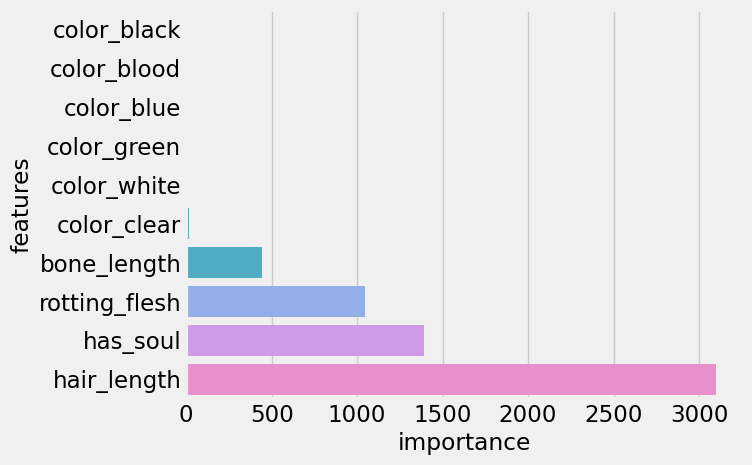

In [12]:
sns.set_context('talk')
style.use('fivethirtyeight')

fi = pd.DataFrame()
fi['features'] = X.columns.values.tolist()
fi['importance'] = lgbm_tuned.booster_.feature_importance(importance_type='gain')

sns.barplot(x='importance',y='features', data=fi.sort_values(by='importance', ascending=True))

Source:

https://thecleverprogrammer.com/2021/01/15/lightgbm-in-machine-learning/